In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import matplotlib.image as mpimg


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

### To avoid compatibility issues between Keras and Tensorflow
tf.compat.v1.disable_eager_execution()

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip /content/celeba-dataset.zip

202599


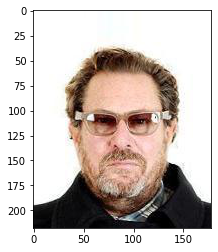

In [ ]:
train_images_glob = glob.glob('/content/img_align_celeba/img_align_celeba/*.jpg')

print(len(train_images_glob))
plt.imshow(mpimg.imread(train_images_glob[2]))
plt.show()

In [ ]:
all_images = []
image_size = 128
train_size = 6000

for i in tqdm(train_images_glob[0:train_size]):
  img = image.load_img(i, target_size=(image_size,image_size,3))
  img = image.img_to_array(img)
  all_images.append(img)
"""Change the data into an np.array"""
all_images = np.array(all_images)
print(len(all_images))

100%|██████████| 6000/6000 [00:06<00:00, 922.21it/s]


6000


In [ ]:

batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 100
num_channels = 3

In [ ]:
x_train, x_test = train_test_split(
                                     all_images, 
                                     shuffle=True,
                                     test_size = 0.2,
                                     random_state=42
                                  )
"""Reshape the data into proper form and normalize"""
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, num_channels)
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, num_channels)
input_shape = (image_size, image_size, num_channels)

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train / 255
x_test = x_test / 255

In [ ]:
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [ ]:
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(100, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
input_shape

(128, 128, 3)

In [ ]:
# Use reparameterization trick
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

In [ ]:
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

In [ ]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

In [ ]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 100), (None, 100) 824892    
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 3)       1414499   
Total params: 2,239,391
Trainable params: 2,229,015
Non-trainable params: 10,376
_________________________________________________________________


In [ ]:
img_width, img_height = x_train.shape[1], x_train.shape[2]

In [ ]:
vae.compile(optimizer='RMSprop', loss=kl_reconstruction_loss)

In [ ]:
vae.fit(x_train, x_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 3840 samples, validate on 960 samples
Epoch 1/50
3840/3840 [==============================] - ETA: 0s - loss: 14435.2065

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3840/3840 [==============================] - 49s 13ms/sample - loss: 14435.2065 - val_loss: 11211.7799
Epoch 2/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9918.3976 - val_loss: 11096.9737
Epoch 3/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9483.8669 - val_loss: 10896.7180
Epoch 4/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9302.6962 - val_loss: 10501.6694
Epoch 5/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9182.9319 - val_loss: 9449.1772
Epoch 6/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9106.6346 - val_loss: 10736.2379
Epoch 7/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 9044.6688 - val_loss: 14145.1254
Epoch 8/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 8980.6174 - val_loss: 11405.8821
Epoch 9/50
3840/3840 [==============================] - 11s 3ms/sample - loss: 8926.5588 - val_loss: 11765.0974
Ep

In [ ]:
vae.fit(x_train, x_train, epochs = 10, batch_size = batch_size, validation_split = 0)

Train on 4800 samples
Epoch 1/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8414.9712
Epoch 2/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8406.0732
Epoch 3/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8395.3401
Epoch 4/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8387.3678
Epoch 5/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8385.0451
Epoch 6/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8382.0566
Epoch 7/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8374.5664
Epoch 8/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8370.0060
Epoch 9/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8366.3208
Epoch 10/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8361.2493


In [ ]:
vae.fit(x_train, x_train, epochs = 30, batch_size = batch_size, validation_split = validation_split)

Train on 3840 samples, validate on 960 samples
Epoch 1/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8357.1269 - val_loss: 8351.2742
Epoch 2/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8348.7866 - val_loss: 8376.7683
Epoch 3/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8344.1581 - val_loss: 8386.2976
Epoch 4/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8341.8827 - val_loss: 8423.8790
Epoch 5/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8335.6862 - val_loss: 8402.2698
Epoch 6/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8330.6907 - val_loss: 8425.8805
Epoch 7/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8339.3047 - val_loss: 8415.2201
Epoch 8/30
3840/3840 [==============================] - 11s 3ms/sample - loss: 8331.0618 - val_loss: 8414.4792
Epoch 9/30
3840/3840 [==============================] - 11s 3ms/s

In [ ]:
vae.fit(x_train, x_train, epochs = 10, batch_size = batch_size, validation_split = 0)

Train on 4800 samples
Epoch 1/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8306.3661
Epoch 2/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8305.6815
Epoch 3/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8297.8961
Epoch 4/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8300.7472
Epoch 5/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8287.0923
Epoch 6/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8294.5130
Epoch 7/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8289.9940
Epoch 8/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8287.8892
Epoch 9/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8283.9198
Epoch 10/10
4800/4800 [==============================] - 13s 3ms/sample - loss: 8291.0502


In [ ]:
predictions = vae.predict(x_test, batch_size = 128)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


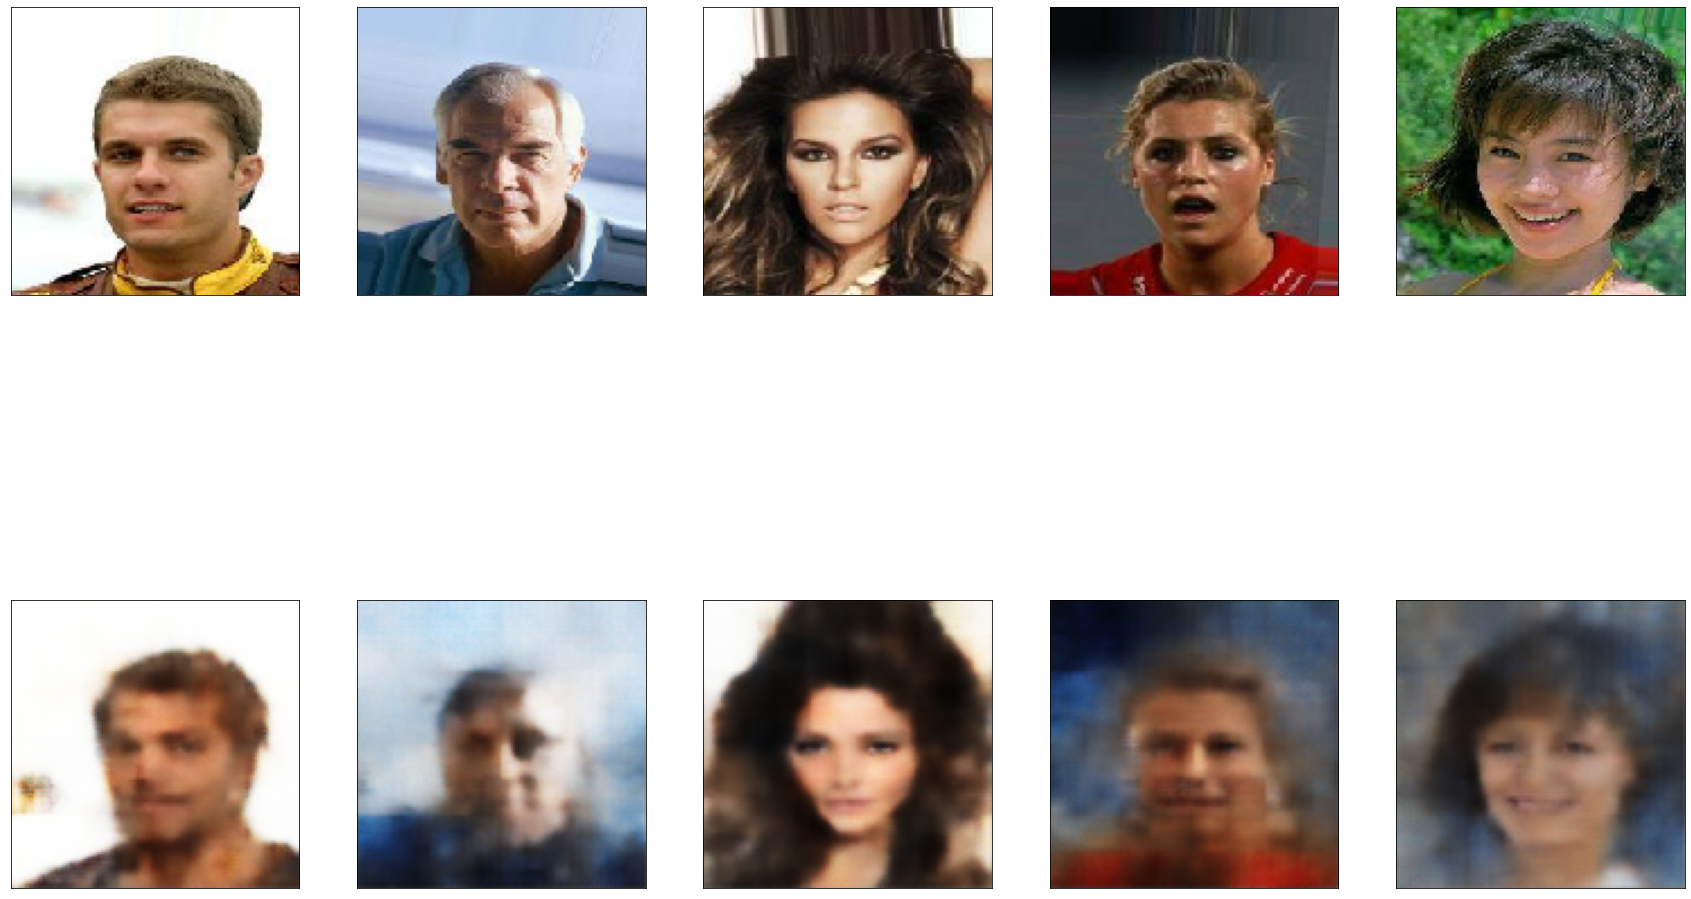

In [ ]:
n = 5
plt.figure(figsize= (30,20))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
#   plt.imshow(val_x_px[i+20])
  plt.imshow(x_test[i+40])  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(predictions[i+40])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# Save/Load model

In [ ]:
vae.save_weights('keras_vae_weights.h5')
vae.save('keras_vae_model.h5')


In [ ]:
!cp /content/keras_vae_weights.h5 /content/drive/MyDrive/AUTOENCODER/keras_celeba_moje_funkcje

In [ ]:
vae.load_weights('vae_weights.h5')

In [ ]:
x_test.shape

(1200, 128, 128, 3)

In [ ]:
encoder.predict() # 128, 128, 3

In [ ]:
uploaded = files.upload()

Saving hindus.jpg to hindus.jpg


In [ ]:
one_image

['/content/one_image/hindus.jpg']

In [ ]:
one_imagetab = []
for i in tqdm(one_image):
  img = image.load_img(i, target_size=(image_size,image_size,3))
  img = image.img_to_array(img)
  one_imagetab.append(img)
"""Change the data into an np.array"""
one_imagetab = np.array(one_imagetab)
print(len(one_imagetab))

100%|██████████| 1/1 [00:00<00:00, 292.84it/s]

1


In [ ]:
"""Reshape the data into proper form and normalize"""
one_imagetab = one_imagetab.reshape(one_imagetab.shape[0], image_size, image_size, num_channels)
input_shape = (image_size, image_size, num_channels)

one_imagetab = one_imagetab.astype("float32")


one_imagetab = one_imagetab / 255


In [ ]:
enocder_one_output = encoder.predict(one_imagetab)

In [ ]:
enocder_one_output = np.array(enocder_one_output)

In [ ]:
enocder_one_output = enocder_one_output.astype("float32")

In [ ]:
enocder_one_output.shape

(3, 1, 100)

In [ ]:
decoder_one_output = decoder.predict(enocder_one_output[2]) # PREDICT TU ZAPOMNIALEM

In [ ]:
print((decoder_one_output.shape))

(1, 128, 128, 3)


In [ ]:
type(decoder_one_output)

numpy.ndarray

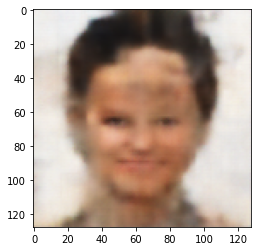

In [ ]:
to_plot = decoder_one_output[0]
plt.imshow(to_plot)  

In [ ]:
one_imagetab          # numpy array from jpg     /// input to encoder
enocder_one_output[2] # z vector                 /// output encoder --- input decoder
decoder_one_output[0] # reconstructed image      /// output decoder 

In [ ]:
# wypluje mi wektor o ktory potem bede przeksztalcac o + albo o -

In [ ]:
from PIL import Image
from numpy import asarray

def get_latent_vector(img_pth, encoder=encoder):
  '''
  input_image - path
  encoder - encoder xD

  output wektor z (ktory podany do decodera daje rekonstrukcje)
  '''
  img = Image.open(img_pth)
  width, height = img.size

  if width != 128 or height != 128:
    img = img.resize((128, 128))
  # asarray() class is used to convert
  # PIL images into NumPy arrays
  numpydata = asarray(img)
  numpydata = numpydata[np.newaxis,:]
  numpydata = numpydata.astype("float32")
  numpydata = numpydata / 255

  latent = encoder.predict(numpydata)
  z = latent[2]
  return z

z_test = get_latent_vector("/content/one_image/hindus.jpg", encoder)

In [ ]:
z_test.shape

(1, 100)

In [ ]:
def get_reconstruction(z, decoder=decoder, plot=False):
  output = decoder.predict(z)

  if plot == True:
    to_plot = output[0]
    plt.imshow(to_plot) 
  return output

reconstructed = get_reconstruction(z_test, decoder, plot=True)

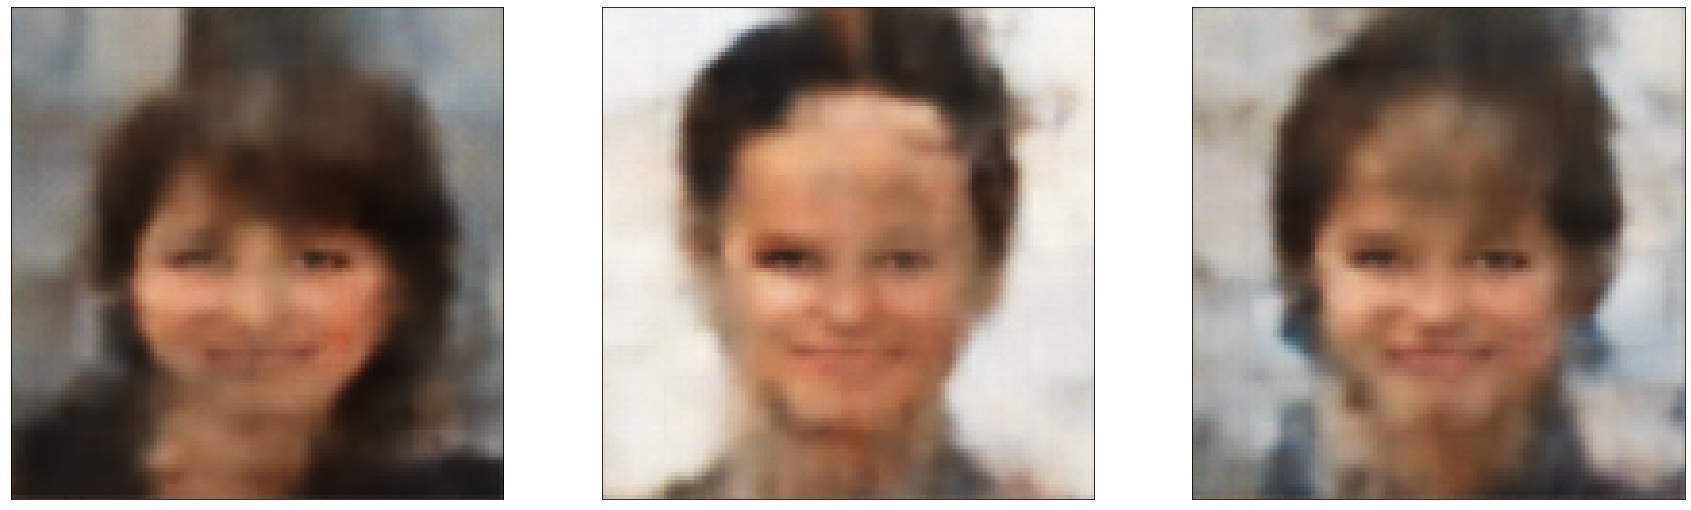

In [ ]:
def morph_2_images(img_pth1, img_pth2, encoder=encoder, decoder=decoder, show=False):
  '''
  Zwraca wektor z pomiedzy 2ma zdjeciami
  '''
  z1 = get_latent_vector(img_pth1)
  z2 = get_latent_vector(img_pth2)
  out_arr = np.add(z1, z2)
  out_arr = out_arr/2

  if show is True:
    tab = []
    reconstructed1 = get_reconstruction(z1)
    tab.append(reconstructed1)
    reconstructed2 = get_reconstruction(z2)
    tab.append(reconstructed2)
    reconstructed3 = get_reconstruction(out_arr)
    tab.append(reconstructed3)
    
    n = 3
    plt.figure(figsize= (30,20))

    tab = asarray(tab)
    tab = tab[:, 0, :,:]
    for i in range(n):
      ax = plt.subplot(2, n, i+1)
      plt.imshow(tab[i])  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False) 
  return out_arr


z_final = morph_2_images("/content/one_image/Woman.jpg", "/content/one_image/hindus.jpg", show=True)

In [ ]:
def get_feature(feature, count=50):
  '''
  n zdjec osob z jasnymi wlosami dodac do siebie i podzielic przez n
  '''
  feature_paths = get_feature_dataset(feature, count)
  feature_vector = np.zeros((1, 100))
  count = len(feature_paths)
  for image in feature_paths:
    z_temp = get_latent_vector("/content/img_align_celeba/img_align_celeba/"+image)
    feature_vector +=z_temp
  feature_vector /= count
  return feature_vector
blond_vector = get_feature("Blond_Hair", count=1000)

In [ ]:
Bald_feature = get_feature("Bald",count=100)

In [ ]:
blond_vector

array([[-0.09951898,  0.01204623,  0.22450097,  0.01054966, -0.00926044,
        -0.01965136,  0.20890506,  0.01818086, -0.12625913, -0.09802686,
        -0.09636872, -0.34321919, -0.04527838, -0.04595431,  0.23529333,
         0.19864378, -0.22486736, -0.34027466, -0.10235697, -0.00280666,
        -0.12581855, -0.13258211,  0.01598593,  0.64385829, -0.04254269,
         0.05757581,  0.03199529, -0.01625774, -0.62626995,  0.27435002,
         0.74940628,  0.03877752,  0.03003145,  0.18852393,  0.95805749,
         0.04180548,  0.05965845,  0.10742279,  0.05592471,  0.0107397 ,
         0.44450844,  0.02537263, -0.07488431, -0.34956778, -0.52771479,
        -0.08957802,  0.020651  , -0.02814527,  0.0327501 ,  0.0285823 ,
        -0.11135004, -0.38406827, -0.17221866, -0.49873979,  0.10453219,
        -0.16996407, -0.04181913,  0.02369712,  0.49282013, -0.40185053,
        -0.10506745,  0.04319964, -0.05949701,  0.0286243 , -0.09814894,
         0.09686553, -0.06791466, -0.03653274,  0.0

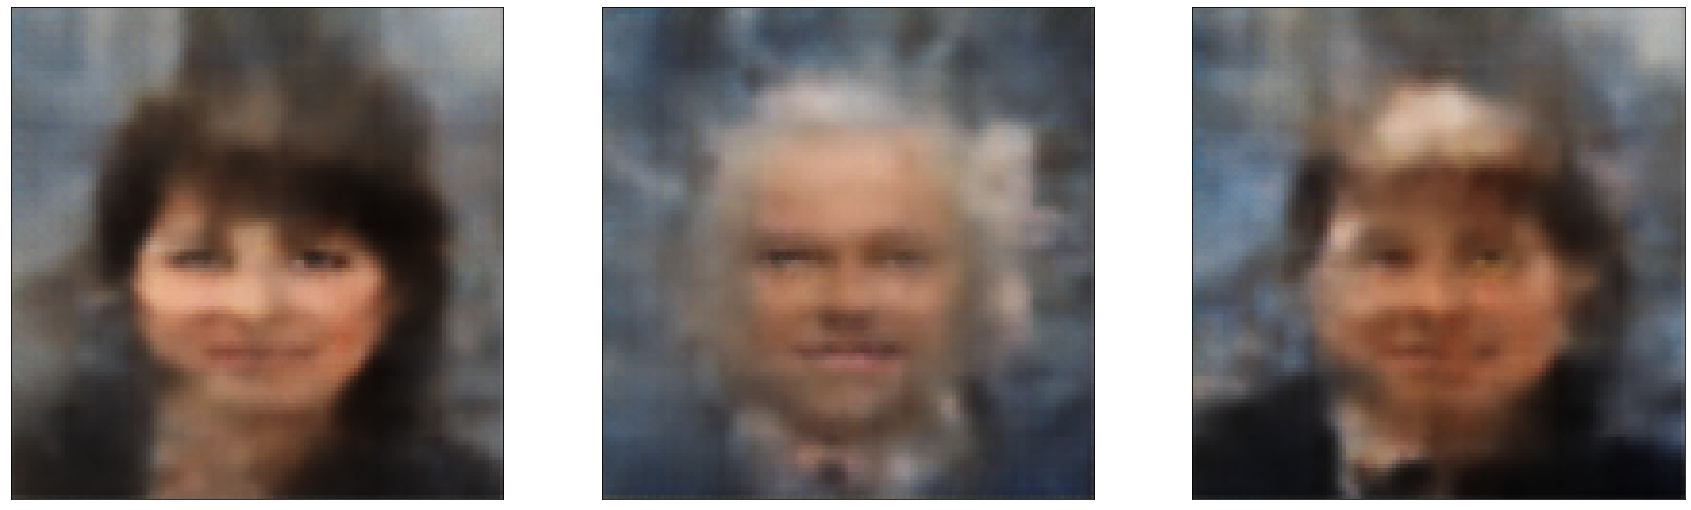

In [ ]:
def add_feature(img_pth1, feature_vector, factor=1 ,encoder=encoder, decoder=decoder, show=False):
  '''
  Zwraca wektor z pomiedzy 2ma zdjeciami
  '''
  z1 = get_latent_vector(img_pth1)
  z2 = feature_vector*factor
  out_arr = np.add(z1, z2)

  if show is True:
    tab = []
    reconstructed1 = get_reconstruction(z1)
    tab.append(reconstructed1)
    reconstructed2 = get_reconstruction(z2)
    tab.append(reconstructed2)
    reconstructed3 = get_reconstruction(out_arr)
    tab.append(reconstructed3)
    
    n = 3
    plt.figure(figsize= (30,20))

    tab = asarray(tab)
    tab = tab[:, 0, :,:]
    for i in range(n):
      ax = plt.subplot(2, n, i+1)
      plt.imshow(tab[i])  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False) 
  return out_arr


# Male_feature = get_feature("Male",count=100)
face_attr = add_feature("/content/one_image/Woman.jpg", Bald_feature, factor=1.5, show=True)

In [ ]:
def get_feature_dataset(feature, count=50, attr_path="/content/list_attr_celeba.csv"):
  '''
  attr_path - path to list_attr_celeba.csv
  feature - e.g. "Blond_Hair" find in attr_path
  count - how many files
  '''
  df = pd.read_csv(attr_path)
  blond_hair = df[df[feature] == 1]
  pandas_series = blond_hair["image_id"].head(count)
  feature_index = pandas_series.to_numpy()
  return feature_index
feature_paths = get_feature_dataset("Blond_Hair", 50)

In [ ]:
feature_paths

# Zrobione

1. potrafie wrzucic przykladowe zdjecie
2. dostac jego z czyli wektor w latent space
3. odkodowac wektor


* teraz zmienic kolor wlosow

In [ ]:
  df = pd.read_csv('/content/list_attr_celeba.csv')
  df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

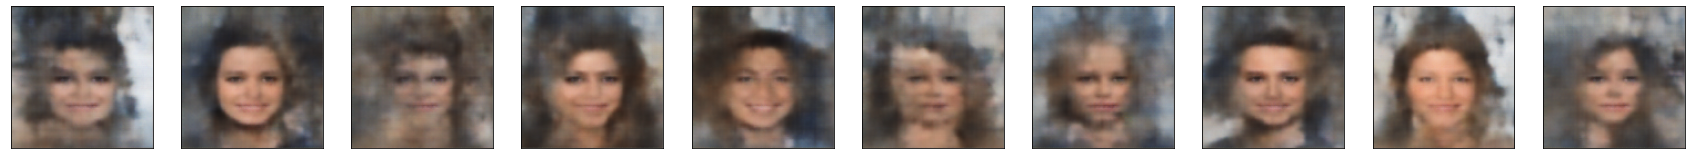

In [ ]:
# generate from random vector test


n = 10
tab = []
for i in range(n):
  sample_vector = np.random.default_rng().uniform(-1,1,100)
  sample_vector = sample_vector.reshape((1, 100))
  a = get_reconstruction(z=sample_vector, decoder=decoder, plot=False)
  tab.append(a)

plt.figure(figsize= (30,20))

tab = asarray(tab)
tab = tab[:, 0, :,:]
for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(tab[i])  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False) 

**Ogarnac jak zrobic unbias feature vector**